Which file would you like to load?  example: Macys.csv  =Macys.csv
What is your minimum support? example: 50% =  89
What is your confidence level percentage? example: 50%   = 95
 
*********************************** Association Rule using Apriori Algorithm **********************************
Created by:  Rayon Myrie
Email:  RM25@njit.edu
Student Id:  Rayon Myrie
CLASS:  CS634 - Data Mining
There are  10 unique items in your dataset. We are checking for items with a minimum support of 70 %
and minimum confidence of 80 %. The items that have a minimum support of  70 % are  ['Jeans' 'Tshirt' 'underwear']
 
 
Table:
col_0      count  support
Jeans         10    100.0
Tshirt        10    100.0
underwear      9     90.0
 
 
 
The combinations for this set are: 
           Jeans  Tshirt  underwear
Jeans       10.0     8.0        5.0
Tshirt       0.0    10.0        5.0
underwear    0.0     0.0        9.0




The support for the frequent pairs are:
                     count  support
Jeans,under

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



The pairs that meet the minumum support are:


                     count  support Min_Conf
Jeans,Tshirt           8.0     80.0       95
underwear,underwear    9.0     90.0       95
Jeans,Jeans           10.0    100.0       95
Tshirt,Tshirt         10.0    100.0       95



The Confidence for the pairs that meet the minumum support are:


   Min_Conf  count_x  count_y     item_x               item_y  support_x  \
0        95       10     10.0      Jeans          Jeans,Jeans      100.0   
1        95       10      8.0     Tshirt         Jeans,Tshirt      100.0   
2        95       10     10.0     Tshirt        Tshirt,Tshirt      100.0   
3        95        9      9.0  underwear  underwear,underwear       90.0   
0        95       10      8.0      Jeans         Jeans,Tshirt      100.0   
1        95       10     10.0      Jeans          Jeans,Jeans      100.0   
2        95       10     10.0     Tshirt        Tshirt,Tshirt      100.0   
3        95        9      9.0  underwear  underwea

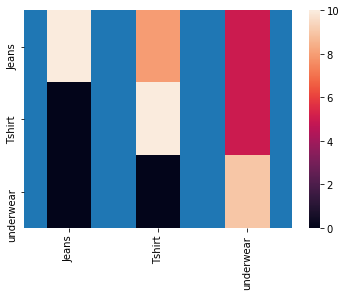

In [745]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import itertools
from collections import Counter
from pandas.tools.plotting import scatter_matrix
from collections import OrderedDict
from fractions import Fraction
import difflib 
import io

##enter percentage of minumum support

## input data
csvfilen =input('Which file would you like to load?  example: Macys.csv  =')
min_support = input('What is your minimum support? example: 50% =  ')
min_con=input('What is your confidence level percentage? example: 50%   = ')

## read data from CSV file
##min_supp = 70
##min_con = 70
##orditem = pd.read_csv('Macys.csv', names = ['order_no','item'])

orditem = pd.read_csv(csvfilen, names = ['order_no','item'])


##count of all items
totitems=orditem['item'].nunique()
## list of all the items
countItem= pd.crosstab(index=orditem["item"],  columns="count").sort_index()


##find support percent
countItem['support']=(countItem['count']/totitems)*100

##find  items above the minumum support
sup2=countItem.loc[countItem['support'] > min_supp]

##bar graph of all items
plot_sup =orditem.item.value_counts().sort_index().plot('bar')

## create basket
cart = (orditem.groupby(['order_no','item'])['item'].count().unstack().reset_index().fillna(' ')
          .set_index('order_no'))


## save transposition of table
cart.to_csv('cartMatrix.csv', sep=',')

## create list of minumim Support items
s=sup2.unstack().reset_index()

s=s.drop(['col_0'], axis=1)

s=s.drop_duplicates()

u=s.item.unique()
#u=u


### Step two 
### reduce input file to only include the frequent Items
red_ord =  pd.merge(orditem,s, on = ['item'], how = 'left').drop_duplicates(['order_no','item'])

red_ord= red_ord.loc[red_ord[0] > 1]
red_ord = red_ord.drop([0], axis=1)
red_cart = (red_ord.groupby(['order_no','item'])['item'].count().unstack().reset_index().fillna(0).set_index('order_no'))
##red_cart=red_cart.drop(['order_no'], axis=1)
red_cart1 =red_ord.pivot(index="order_no", columns="item", values="item").fillna(0)


###########################
###
###   Test code
##red_cart =pd.merge(red_cart,red_cart, how='left', left_on='order_no', right_on = 'order_no')

##res = pd.merge(red_cart, red_cart, on='_tmpkey').drop('_tmpkey', axis=1)
##res.index = pd.MultiIndex.from_product((red_cart.index, red_cart.index))
##
############################

##Save matrix of Frequent Items to a CSV file for review and QA purposes(red_cart)
red_cart.to_csv('Freq_matrix.csv', sep=',')
#############################################


#############################################
##
##  Find frequent Pairs
## 
#############################################


# take data matrix from dataframe
redcart_matrix = red_cart.as_matrix()
# get row and column Data
rows, columns = redcart_matrix.shape
redcart_frIt_matrix = np.zeros((columns,columns))
##print(redcart_frIt_matrix )
for c1_fr_set in range(0, 20):
    for next_column in range(c1_fr_set , columns):
        # multiply product pair vectors
        product_vector = redcart_matrix[:,c1_fr_set] * redcart_matrix[:,next_column]
        # check the number of pair occurrences in baskets
        count_matches = sum((product_vector))
        # save values to new matrix
        redcart_frIt_matrix[c1_fr_set,next_column] = count_matches
        frequent_items_df = pd.DataFrame(redcart_frIt_matrix, columns = red_cart.columns.values, index = red_cart.columns.values)

##print(frequent_items_df)
item = frequent_items_df.columns.values

##print(item)
#sb.heatmap(frequent_items_df)

##############
####  The orginal code for frequent pairs did not work, so I modifide a code I found that plotted a graph of frequent 
####  pairs.
##############
def extract_pairs(treshold):
    output = {}
    #select indexes with larger or equal n
    matrix_coord_list = np.where(redcart_frIt_matrix >= treshold)
    ##print(matrix_coord_list)
    # take values
    row_coords = matrix_coord_list[0]
    column_coords = matrix_coord_list[1]  
    #column_coord2 = matrix_coord_list[1] 
          
    for index, value in enumerate(row_coords):
            row = row_coords[index]
            column = column_coords[index]
          #  column2 = column_coords2[index]
        # get product names
            first_product = item[row]
            second_product = item[column]
            #third_product = item[column2]
            #third_product = item[column2]
            matches = redcart_frIt_matrix[row,column]
            output[first_product+","+second_product] = matches
            sorted_output = OrderedDict(sorted(output.items(), key=lambda x: x[1]))
            ##print  (matches)
    return sorted_output  
############################################################    
print  (" ")  

n2 = pd.Series(extract_pairs(1))
n2_frame =pd.DataFrame(data=n2, columns=['count'])
n2_frame['support']=(n2_frame['count']/totitems)*100
n2_frame_sup2=n2_frame.loc[n2_frame['support'] > min_supp]

n2_frame_sup2.index.name= None
sup2.index.name= None

n2_frame_sup2['Min_Conf']=min_con
n2_frame_sup2.to_csv('pair_support.csv', sep=',')  
sup2.to_csv('indv_support.csv', sep=',')

indiv_sup = pd.read_csv('indv_support.csv', names = ['item','count','support'],skiprows=[0])
n2_support = pd.read_csv('pair_support.csv', names = ['item','count','support','Min_Conf'],skiprows=[0])
### Add first 3 values to a new column as index
n2_support['item1'] = n2_support['item'].str[:3]
indiv_sup['item1'] = indiv_sup['item'].str[:3]
### Add last 3 values to a new column as index
n2_support['item2'] = n2_support['item'].str[-3:]
indiv_sup['item2'] = indiv_sup['item'].str[-3:]
##########
### Merge dataframes to find the confidence ####
mer_df1=pd.merge(indiv_sup,n2_support,how='left', left_on = 'item2', right_on = 'item2')
mer_df2=pd.merge(indiv_sup,n2_support,how='left', left_on = 'item1', right_on = 'item1')
mer_df3=pd.concat([mer_df1,mer_df2],)  
#drop columns
mer_df3=mer_df3.drop(['item1','item1_x','item1_y','item2','item2_x','item2_y'], axis=1)
##mer_df3=mer_df3.drop_duplicates()
##print(mer_df1)
######################################
###
###   Calculate confidence
###
######################################
mer_df3['Confidence']=(mer_df3['support_y']/mer_df3['support_x'])*100
##print(mer_df3)

##### find minumum confidence 
mer_df4=mer_df3.loc[mer_df3['Confidence'] > mer_df3['Min_Conf']]


mer_df4=mer_df4.drop(['count_x','count_y', 'support_x'], axis=1)

##print(n2_support)
print('*********************************** Association Rule using Apriori Algorithm **********************************')

###########################################################
###
###
###  Print Statements
###
###
###########################################################
print('Created by:  Rayon Myrie')
print('Email:  RM25@njit.edu')
print('Student Id:  Rayon Myrie')
print('CLASS:  CS634 - Data Mining')
print("There are ", totitems, "unique items in your dataset. We are checking for items with a minimum support of",min_supp,'%') 
print("and minimum confidence of", min_confid,"%. The items that have a minimum support of ", min_supp,"% are ",u)
print(' ')
print(' ')
print('Table:')
print(sup2)
print(' ')
print(' ')
print(' ')
print('The combinations for this set are: ')
print(frequent_items_df)
print ('')
print ('')
print ('')
print ('')
print('The support for the frequent pairs are:')
print(n2_frame)
print ('')
print ('')
print ('')
print ('')

print('The pairs that meet the minumum support are:')
print ('')
print ('')
print(n2_frame_sup2)
print ('')
print ('')
print ('')
print('The Confidence for the pairs that meet the minumum support are:')
print ('')
print ('')
print(mer_df3)
print ('')
print ('')
print('The Items that meet the minimum Confidence are:')
print ('')
print ('')
print(mer_df4)
print ('')
print ('')

######################################################################
print ('The Most frequent combinations are:')
print ('if the code was working correctly it would report the support and confidence for all the items below')
#####################################################################
#####  old code ------ Does not work- it finds the frequent pairs but does not give an acurate count.
####                   I used this coulde for testing purposes.  This would be the best code, if 
###                    count and return feature was working propurely.
###    find pairs of sets N >2 using Cross
##     create sets for minumum supported items in basket
##     find pairs using Naive approach
######## Print#####################################################################

c1frset = []
for L in range(1, 10):
    for c1frset in list(itertools.combinations(red_cart, L)):
        freq1 = ','.join(c1frset)
        freq=pd.Series(freq1)
        freq=pd.DataFrame(data=freq)
    print (freq1)
print ('')    

#print (pd.Series(orted_output))
#plot_sup2 =frequent_items_df.support.sort_index().plot('bar')
plot_sup2 =sns.heatmap(frequent_items_df)
print(' ')
print('Graph')
print(plot_sup2) 



